<h1>MC Dropout</h1>
<h3>This notebook was made to show Monte Carlo Dropout. The accuracy and performance can be enhance by tweaking the model and finetuning. However, that is not the goal of this notebook.</h3>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
# @title
# seed_value= 0

# # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
# import os
# os.environ['PYTHONHASHSEED']=str(seed_value)

# # 2. Set `python` built-in pseudo-random generator at a fixed value
# import random
# random.seed(seed_value)

# # 3. Set `numpy` pseudo-random generator at a fixed value
# np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(seed_value)
# # for later versions:
# # tf.compat.v1.set_random_seed(seed_value)

# # 5. Configure a new global `tensorflow` session
# # for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [3]:
#set the random seed to reproduce results
keras.utils.set_random_seed(20)
tf.config.experimental.enable_op_determinism()

np.random.seed(20)

#Set common values
NUMBER_SAMPLES=20
dropout_rate=0.3
epochs=10

<h2>Downloading the data</h2>

In [4]:

'''
  doc of dataset in the link below:
  https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
  10 classes

  Label	  Description
  0	      airplane
  1	      automobile
  2	      bird
  3	      cat
  4	      deer
  5	      dog
  6	      frog
  7	      horse
  8	      ship
  9	      truck


'''
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

<h2> verify the shape of the data</h2>

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
x_test.shape

(10000, 32, 32, 3)

<h2>Visualize the images</h2>

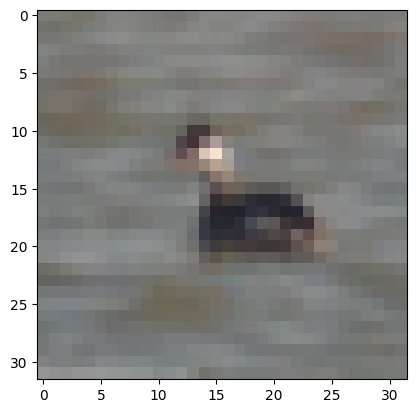

In [7]:
i=1500
plt.imshow(x_train[i])

<h2>MC DROPOUT IMPLEMENTATION</h2>

In [8]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        # It is regular dropout but it is always in training mode even during testing.
        return super().call(inputs, training=True)

<h2>Create The Models</h2>

In [9]:
MC_model= keras.Sequential(
    [
        keras.layers.Input((32,32,3)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(10,(5,5)),
        keras.layers.MaxPooling2D(),
        MCDropout(dropout_rate),
        keras.layers.Conv2D(10,(3,3)),
        keras.layers.MaxPooling2D(),
        MCDropout(dropout_rate),
        keras.layers.Flatten(),
        keras.layers.Dense(50,activation='relu'),
        keras.layers.Dense(10,activation='softmax')
    ]
)

MC_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model= keras.Sequential(
    [
        keras.layers.Input((32,32,3)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(10,(5,5)),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Conv2D(10,(3,3)),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Flatten(),
        keras.layers.Dense(50,activation='relu'),
        keras.layers.Dense(10,activation='softmax')
    ]
)

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [10]:
MC_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 32, 32, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 10)        0         
 D)                                                              
                                                                 
 mc_dropout (MCDropout)      (None, 14, 14, 10)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 10)          0

In [11]:
MC_model.fit(x_train,y_train,epochs=epochs)

Epoch 1/10
1563/1563 [==============================] - 18s 6ms/step - loss: 1.6839 - accuracy: 0.3957
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4088 - accuracy: 0.4963
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3046 - accuracy: 0.5363
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2391 - accuracy: 0.5615
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2024 - accuracy: 0.5729
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1659 - accuracy: 0.5878
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1380 - accuracy: 0.5997
Epoch 8/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1211 - accuracy: 0.6056
Epoch 9/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1008 - accuracy: 0.6150
Epoch 10/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.08

In [12]:

start=time.time()
MC_predictions=np.stack([MC_model.predict(x_test,verbose=0)for sample in range(NUMBER_SAMPLES)])
print(f'it took MC {np.round(time.time()-start,2)} sec to predict\n\n')

MC_pred=MC_predictions.mean(axis=0)
MC_std=MC_predictions.std(axis=0)
MC_pred

it took MC 25.85 sec to predict


array([[2.05571204e-02, 1.17041711e-02, 4.45106141e-02, ...,
        1.82583986e-03, 1.30546495e-01, 6.09272160e-03],
       [1.21259227e-01, 5.62277913e-01, 9.54863135e-05, ...,
        5.45372768e-06, 3.05916935e-01, 1.03067067e-02],
       [1.63808823e-01, 2.05321744e-01, 1.12674236e-02, ...,
        1.99357374e-03, 5.93184173e-01, 1.72594711e-02],
       ...,
       [2.09712936e-03, 5.85694806e-06, 1.35736957e-01, ...,
        7.46279806e-02, 8.27767944e-05, 8.04816809e-05],
       [1.14346206e-01, 5.35136819e-01, 4.74606492e-02, ...,
        3.54654305e-02, 4.59567904e-02, 1.40072796e-02],
       [4.63964010e-04, 5.57380554e-04, 2.20047049e-02, ...,
        8.08184803e-01, 2.20462491e-04, 1.02875894e-03]], dtype=float32)

In [13]:
MC_predictions.shape

(20, 10000, 10)

In [14]:
MC_pred.shape

(10000, 10)

In [15]:
y_test.shape

(10000, 1)

In [16]:
np.round(MC_pred,3)

array([[0.021, 0.012, 0.045, ..., 0.002, 0.131, 0.006],
       [0.121, 0.562, 0.   , ..., 0.   , 0.306, 0.01 ],
       [0.164, 0.205, 0.011, ..., 0.002, 0.593, 0.017],
       ...,
       [0.002, 0.   , 0.136, ..., 0.075, 0.   , 0.   ],
       [0.114, 0.535, 0.047, ..., 0.035, 0.046, 0.014],
       [0.   , 0.001, 0.022, ..., 0.808, 0.   , 0.001]], dtype=float32)

In [17]:
np.round(MC_std,3)

array([[0.018, 0.009, 0.044, ..., 0.002, 0.12 , 0.007],
       [0.104, 0.219, 0.   , ..., 0.   , 0.207, 0.007],
       [0.163, 0.157, 0.008, ..., 0.002, 0.225, 0.018],
       ...,
       [0.002, 0.   , 0.126, ..., 0.068, 0.   , 0.   ],
       [0.1  , 0.272, 0.034, ..., 0.043, 0.055, 0.014],
       [0.   , 0.001, 0.016, ..., 0.124, 0.   , 0.002]], dtype=float32)

MC Accuracy

In [18]:
MC_scores=np.argmax(MC_pred,axis=1)==y_test.ravel()
MC_accuracy=np.sum(MC_scores)/len(y_test)
MC_accuracy

0.6484

Check a wrong prediction

In [19]:
for i in range(len(MC_scores)):
  if not MC_scores[i]:
    print(i)
    break

print(np.round(MC_pred[i],2))
print(np.round(MC_std[i],2))
print(y_test.ravel()[i])

1
[0.12 0.56 0.   0.   0.   0.   0.   0.   0.31 0.01]
[0.1  0.22 0.   0.   0.   0.   0.   0.   0.21 0.01]
8


The model predicted class 1 with 56% probability as the correct class. However, the correct class (class 8) had a probability of 31% . If we look at STD, class 1 has a STD of 0.22 while class 8 had a STD of 0.21. It shows that the model is uncertain about its prediction.<br/><br/>
The STD allows us to conclude that either of the 2 classes could be the correct class and we can asses the risk of mislabelling. Then, the class that reduces risk would be selected.  

<h2>now train a model with the regular dropout</h2>

In [20]:
#model.fit(x_train,y_train,epochs=epochs)

#instead of retraining, we will transfer the weights from the first model to this one to ensure both have the same weights/parameters
#Note that this works because the models are identical with only difference is that MC model uses dropout during inference
model.set_weights(MC_model.get_weights())

In [21]:
start=time.time()
predictions=model.predict(x_test,verbose=0)
print(f'it took regular model {np.round(time.time()-start,2)} sec to predict')

scores=np.argmax(predictions,axis=1)==y_test.ravel()

it took regular model 1.66 sec to predict


Accuracy with regular dropout

In [22]:
model_accuracy=np.sum(scores)/len(y_test)
model_accuracy

0.6022

In [23]:
for j in range(len(scores)):
  if not scores[j]:
    print(j)
    break

print(np.round(predictions[j],2))
print(y_test.ravel()[j])

8
[0.01 0.   0.32 0.18 0.12 0.02 0.35 0.   0.   0.  ]
3


The model predicted class 6 with prob 35% while the correct class had a prob of 18%. There is no reason/indication to even question the prediction because it have the highest score.

<h1>Conclusion</h1>

In general, the model that used Monte Carlo Dropout got better accuracy (from 60% to 64%) and a measurement for uncertainty of its predictions. However, inference/testing time was a lot higher (16x) as the model predicts the value of each sample many times. In some high risk scenarios, medical or finance, it could be justified as the risk of mislabeling is too high. <br/><br/>
MC Dropout requires a trade-off between speed and certainty. It should be used in risky enviroments where certainty of predictions is necessary.